## Emotion Recognition from Speech Using Wav2vec 2.0 Embeddings
https://www.isca-archive.org/interspeech_2021/pepino21_interspeech.pdf
https://publications.idiap.ch/attachments/papers/2025/Purohit_ICASSP-2_2025.pdf
https://arxiv.org/pdf/2107.04734

In this notebook we will do the following
- Extract the embeddings from wav2vec (CNN + Transformer)
- Check how powerful the embeddings are to recognise emotions without the fine tuning the wav2vec model.

This can be done in 2 ways. 
- Zero shot classification

In [2]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["OMP_NUM_THREADS"] = "15"

# Import model classes
from transformers.models.wav2vec2 import Wav2Vec2Model
from transformers.models.hubert import HubertModel
from transformers.models.wavlm import WavLMModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/ghs6kor/miniconda3/envs/dl_lab_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the models
- Models are loaded
- Audio is processed
- EMbeddings are extracted from the models

In [3]:
class SpeechModelWrapper:
    """
    Wrapper class for self-supervised speech models.
    Loads a model (Wav2Vec2, Hubert, or WavLM) with hidden states enabled,
    processes audio, and extracts embeddings from both:
      - CNN (feature extraction) layers, and
      - Transformer encoder layers.
    """
    def __init__(self, model_name):
        self.model = self.load_model(model_name)
        self.model.to(device)
        self.model.eval()
        self.model_type = self._get_model_type(model_name)

    def _get_model_type(self, model_name):
        if "wav2vec2" in model_name:
            return "wav2vec2"
        elif "hubert" in model_name:
            return "hubert"
        elif "wavlm" in model_name:
            return "wavlm"
        else:
            return "unknown"

    def load_model(self, model_name):
        if "wav2vec2" in model_name:
            model = Wav2Vec2Model.from_pretrained(model_name, output_hidden_states=True)
        elif "hubert" in model_name:
            model = HubertModel.from_pretrained(model_name, output_hidden_states=True)
        elif "wavlm" in model_name:
            model = WavLMModel.from_pretrained(model_name, output_hidden_states=True)
        else:
            raise ValueError("Unsupported model name.")
        return model

    def process_audio(self, audio, sampling_rate=16000):
        """
        Converts a 1D numpy array into a tensor with a batch dimension.
        """
        input_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0)  # Shape: (1, sequence_length)
        return {"input_values": input_tensor.to(device)}

    def extract_cnn_embeddings_all_layers(self, inputs):
        """
        Extracts CNN embeddings by registering hooks on each convolutional layer.
        Returns a list (one per CNN layer) with shape (batch, time, feature_dim).
        """
        cnn_outputs = {}
        hooks = []
        conv_layers = self.model.feature_extractor.conv_layers
        for idx, layer in enumerate(conv_layers):
            def get_hook(index):
                def hook(module, input, output):
                    cnn_outputs[index] = output.detach()
                return hook
            handle = layer.register_forward_hook(get_hook(idx))
            hooks.append(handle)
        with torch.no_grad():
            _ = self.model(**inputs)
        for handle in hooks:
            handle.remove()
        # Return embeddings sorted by layer index.
        embeddings = [cnn_outputs[i] for i in sorted(cnn_outputs.keys())]
        return embeddings

    def extract_transformer_embeddings_all_layers(self, inputs):
        """
        Extracts transformer (encoder) embeddings from all layers.
        Returns the tuple of hidden states (batch, time, hidden_dim).
        """
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.hidden_states

#  Load the plots

In [19]:
def plot_tsne(embeddings, labels, title="t-SNE Plot", save_path=None):
    """
    Projects embeddings into 2D space using t-SNE for visualization.
    """
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    for lab in np.unique(labels):
        idx = labels == lab
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=str(lab), alpha=0.7)
    plt.title(title)
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Actions on embeddings
- Train Linear Classifier (SVM)
- Zero Shot classification 


In [ ]:



def zero_shot_classification(embeddings, labels, test_size=0.5):
    """
    Splits embeddings and labels (50/50), computes class prototypes from training data,
    and classifies test samples based on cosine similarity to prototypes.
    Returns accuracy, predictions, and true test labels.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=test_size, random_state=42, stratify=labels
    )
    prototypes = {}
    for lab in np.unique(y_train):
        prototypes[lab] = X_train[y_train == lab].mean(axis=0)

    predictions = []
    for emb in X_test:
        sims = {lab: np.dot(emb, proto) / (np.linalg.norm(emb) * np.linalg.norm(proto))
                for lab, proto in prototypes.items()}
        pred = max(sims, key=sims.get)
        predictions.append(pred)

    predictions = np.array(predictions)
    acc = accuracy_score(y_test, predictions)
    return acc, predictions, y_test


def train_linear_classifier(embeddings, labels):
    """
    Trains a linear SVM as a linear probe using an 80/20 split.
    Returns accuracy and the trained classifier.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    clf = LinearSVC(max_iter=10000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc, clf


def load_dataset_from_paths(paths_file, target_sr=16000):
    """
    Reads file paths from 'paths_file', extracts the emotion label (assumes folder after 'emotions'),
    and loads the corresponding audio.
    Returns a list of audio waveforms and corresponding labels.
    """
    file_paths = []
    with open(paths_file, 'r') as f:
        for line in f:
            path = line.strip()
            if path:
                file_paths.append(path)

    emotions = ["angry", "apologetic", "base", "calm", "excited", "fear", "happy", "sad"]
    emotion_to_idx = {emo: i for i, emo in enumerate(emotions)}

    data = []
    labels = []
    for path in file_paths:
        parts = path.split(os.sep)
        try:
            emo_index = parts.index("emotions")
            emotion = parts[emo_index + 1].lower()
        except ValueError:
            print(f"Warning: 'emotions' not found in path: {path}")
            continue
        if emotion not in emotion_to_idx:
            print(f"Warning: emotion '{emotion}' not recognized, skipping: {path}")
            continue
        try:
            audio, sr = librosa.load(path, sr=target_sr)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue
        data.append(audio)
        labels.append(emotion_to_idx[emotion])

    return data, np.array(labels)


def extract_embeddings(wrapper, data, cache_dir, model_type):
    """
    Extract embeddings for all samples and all layers, with CUDA optimization.
    Returns CNN layer embeddings and transformer layer embeddings.
    """
    # Determine cache file paths
    cnn_cache_file = os.path.join(cache_dir, f"{model_type}_cnn_layers_embeddings.npy")
    trans_cache_file = os.path.join(cache_dir, f"{model_type}_transformer_layers_embeddings.npy")

    # Check for cached embeddings
    if os.path.exists(cnn_cache_file) and os.path.exists(trans_cache_file):
        print(f"Loading cached embeddings for {model_type}...")
        cnn_layers_embeddings = np.load(cnn_cache_file, allow_pickle=True)
        transformer_layers_embeddings = np.load(trans_cache_file, allow_pickle=True)
        return cnn_layers_embeddings, transformer_layers_embeddings

    # Determine layer counts
    sample_inputs = wrapper.process_audio(data[0])
    cnn_sample = wrapper.extract_cnn_embeddings_all_layers(sample_inputs)
    transformer_sample = wrapper.extract_transformer_embeddings_all_layers(sample_inputs)
    num_cnn_layers = len(cnn_sample)
    num_transformer_layers = len(transformer_sample)
    print(f"Number of CNN layers for {model_type}: {num_cnn_layers}")
    print(f"Number of Transformer layers for {model_type}: {num_transformer_layers}")

    # Initialize embedding lists
    cnn_layers_embeddings = [[] for _ in range(num_cnn_layers)]
    transformer_layers_embeddings = [[] for _ in range(num_transformer_layers)]

    # Process batches of data to optimize GPU usage
    batch_size = 16  # Adjust based on GPU memory
    num_samples = len(data)
    num_batches = (num_samples + batch_size - 1) // batch_size

    print(f"Extracting embeddings for {model_type} model...")
    for batch_idx in tqdm(range(num_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        batch_data = data[start_idx:end_idx]

        for audio in batch_data:
            # Process each audio sample
            inputs = wrapper.process_audio(audio)

            # Extract CNN embeddings - optimize for GPU
            cnn_embs = wrapper.extract_cnn_embeddings_all_layers(inputs)
            for layer_idx in range(num_cnn_layers):
                # Average over time dimension (dim=2)
                avg = cnn_embs[layer_idx].mean(dim=2).cpu().numpy()
                emb = avg[0] if (avg.ndim == 2 and avg.shape[0] == 1) else avg
                cnn_layers_embeddings[layer_idx].append(emb)

            # Extract Transformer embeddings
            trans_embs = wrapper.extract_transformer_embeddings_all_layers(inputs)
            for layer_idx in range(num_transformer_layers):
                avg = trans_embs[layer_idx].mean(dim=1).cpu().numpy()
                emb = avg[0] if (avg.ndim == 2 and avg.shape[0] == 1) else avg
                transformer_layers_embeddings[layer_idx].append(emb)

        # Clear CUDA cache periodically
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Convert lists to numpy arrays for each layer
    cnn_layers_embeddings = [np.stack(layer_embs, axis=0) for layer_embs in cnn_layers_embeddings]
    transformer_layers_embeddings = [np.stack(layer_embs, axis=0) for layer_embs in transformer_layers_embeddings]

    # Save embeddings to cache
    np.save(cnn_cache_file, cnn_layers_embeddings)
    np.save(trans_cache_file, transformer_layers_embeddings)
    print(f"Saved {model_type} embeddings to cache.")

    return cnn_layers_embeddings, transformer_layers_embeddings

def print_cnn_embeddings_shape(cnn_outputs):
    """
    Prints the shapes of CNN embeddings from the Wav2Vec 2.0 feature extractor.

    Parameters:
    cnn_outputs (dict): Dictionary containing CNN layer outputs, indexed by layer number.
    """

    print("\n=== CNN Embeddings ===\n")
    print(f"{'Layer':<10}{'Output Shape':<30}{'Description'}")
    print("=" * 70)

    for layer_idx, output in cnn_outputs.items():
        shape = output.shape  # Expected format: (batch_size, channels, time_steps)
        batch_size, num_channels, time_steps = shape

        description = (
            "Raw feature extraction" if layer_idx == 0 else
            "Further downsampled" if layer_idx < max(cnn_outputs.keys()) else
            "Final compressed representation"
        )

        print(f"{layer_idx:<10}{str(shape):<30}{description}")

    print("\nNote: Time steps decrease as the layers go deeper due to CNN downsampling.")


In [14]:
print("Starting analysis of speech embeddings for emotion recognition.\n")
start_time = time.time()
print(start_time)

# ----------------------------
# Model Definitions
# ----------------------------
model_configs = [
    {"name": "facebook/wav2vec2-base", "label": "Wav2Vec2"},
    {"name": "facebook/hubert-base-ls960", "label": "HuBERT"},
    {"name": "microsoft/wavlm-base", "label": "WavLM"},
]

# ----------------------------
# Load Dataset
# ----------------------------
data, labels = load_dataset_from_paths("emotions/paths_emo_eng_gc", target_sr=16000)

if len(data) == 0:
    print("No audio files loaded. Please check the paths file.")

print(f"Loaded {len(data)} audio samples with {len(np.unique(labels))} emotion classes.\n")

# ----------------------------
# Setup Cache Directory
# ----------------------------
cache_dir = "embeddings_cache"
os.makedirs(cache_dir, exist_ok=True)

# ----------------------------
# Process Each Model
# ----------------------------
models_data = {}

for model_config in model_configs:
    model_name = model_config["name"]
    model_label = model_config["label"]
    print(f"\nProcessing model: {model_label} ({model_name})")

    # Load model
    wrapper = SpeechModelWrapper(model_name)

    # Extract embeddings
    cnn_layers_embeddings, transformer_layers_embeddings = extract_embeddings(
        wrapper, data, cache_dir, wrapper.model_type
    )

    # Store data for plotting
    models_data[model_label] = {
        "cnn_layers": cnn_layers_embeddings,
        "transformer_layers": transformer_layers_embeddings,
        "cnn_zs_acc": [],
        "cnn_lp_acc": [],
        "transformer_zs_acc": [],
        "transformer_lp_acc": [],
        "num_cnn_layers": len(cnn_layers_embeddings),
        "num_transformer_layers": len(transformer_layers_embeddings)
    }

    # Layer-wise analysis
    print(f"\nPerforming layer-wise analysis for {model_label}...")
    for i in range(len(cnn_layers_embeddings)):
        emb = cnn_layers_embeddings[i]
        acc_zs, _, _ = zero_shot_classification(emb, labels)
        models_data[model_label]["cnn_zs_acc"].append(acc_zs)
        acc_lp, _ = train_linear_classifier(emb, labels)
        models_data[model_label]["cnn_lp_acc"].append(acc_lp)

    for i in range(len(transformer_layers_embeddings)):
        emb = transformer_layers_embeddings[i]
        acc_zs, _, _ = zero_shot_classification(emb, labels)
        models_data[model_label]["transformer_zs_acc"].append(acc_zs)
        acc_lp, _ = train_linear_classifier(emb, labels)
        models_data[model_label]["transformer_lp_acc"].append(acc_lp)


Starting analysis of speech embeddings for emotion recognition.

1742728641.977622
Loaded 2843 audio samples with 8 emotion classes.


Processing model: Wav2Vec2 (facebook/wav2vec2-base)


/Users/ghs6kor/miniconda3/envs/dl_lab_py310/lib/python3.10/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Number of CNN layers for wav2vec2: 7
Number of Transformer layers for wav2vec2: 13
Extracting embeddings for wav2vec2 model...


100%|██████████| 178/178 [13:06<00:00,  4.42s/it]


Saved wav2vec2 embeddings to cache.

Performing layer-wise analysis for Wav2Vec2...

Processing model: HuBERT (facebook/hubert-base-ls960)
Number of CNN layers for hubert: 7
Number of Transformer layers for hubert: 13
Extracting embeddings for hubert model...


100%|██████████| 178/178 [12:40<00:00,  4.27s/it]


Saved hubert embeddings to cache.

Performing layer-wise analysis for HuBERT...

Processing model: WavLM (microsoft/wavlm-base)
Number of CNN layers for wavlm: 7
Number of Transformer layers for wavlm: 13
Extracting embeddings for wavlm model...


100%|██████████| 178/178 [12:54<00:00,  4.35s/it]


Saved wavlm embeddings to cache.

Performing layer-wise analysis for WavLM...


Saved zero-shot comparison plot to output_plots/zero_shot_comparison.png


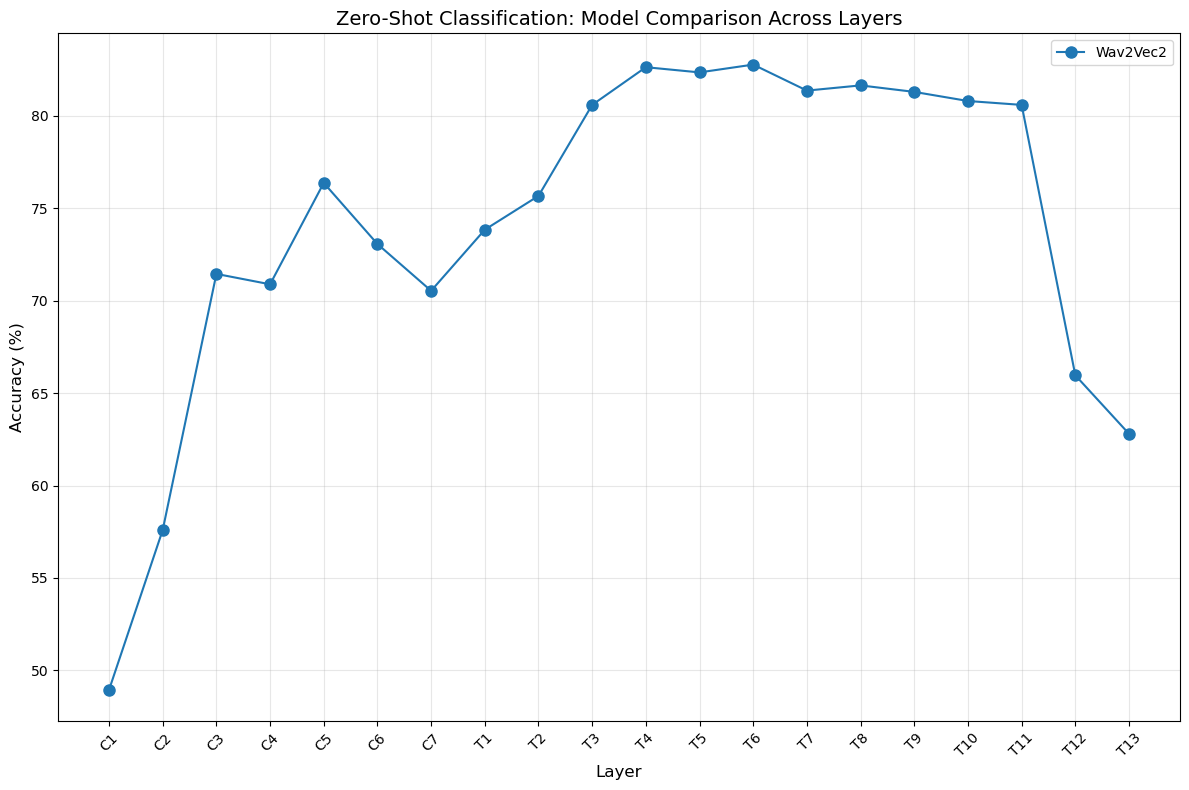

Saved linear probe comparison plot to output_plots/linear_probe_comparison.png


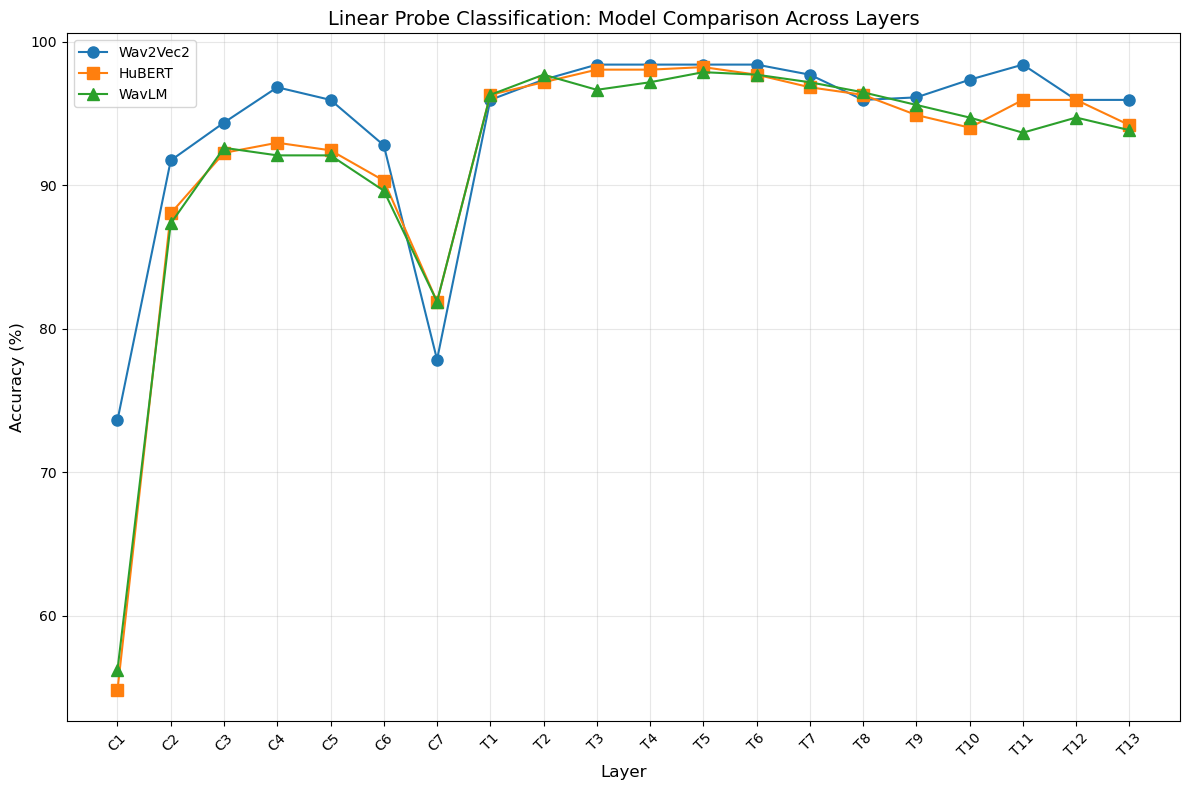


Analysis complete.

Time required  :  2428.1895940303802
Saved zero-shot comparison plot to output_plots/zero_shot_comparison.png


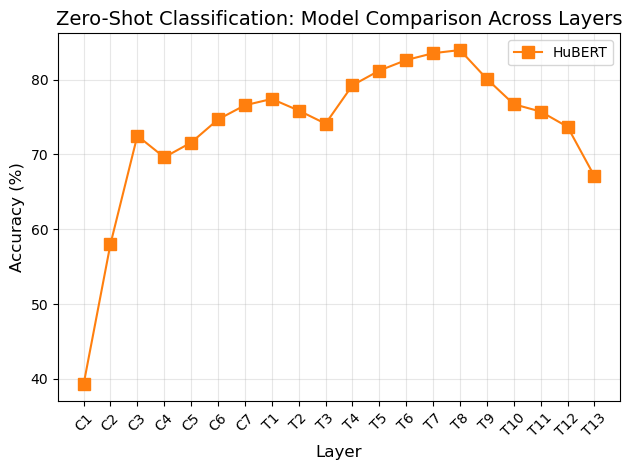

Saved linear probe comparison plot to output_plots/linear_probe_comparison.png


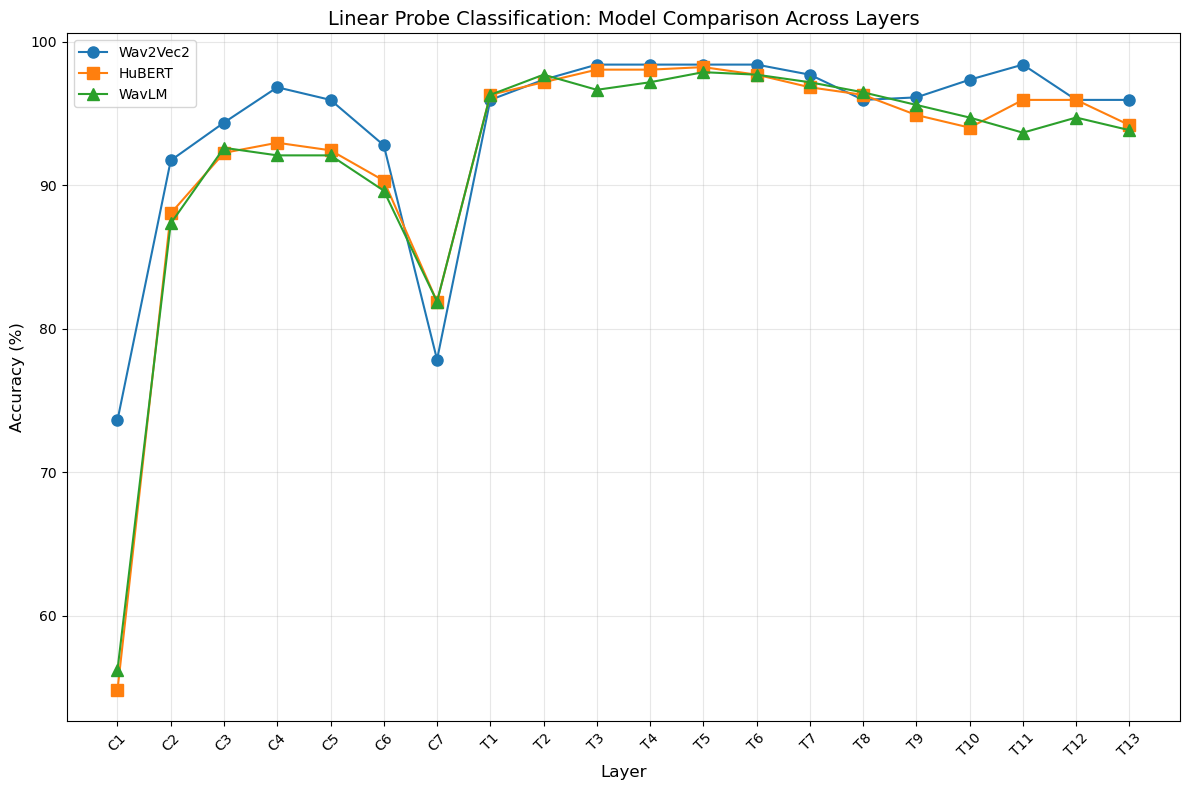


Analysis complete.

Time required  :  2428.77645111084
Saved zero-shot comparison plot to output_plots/zero_shot_comparison.png


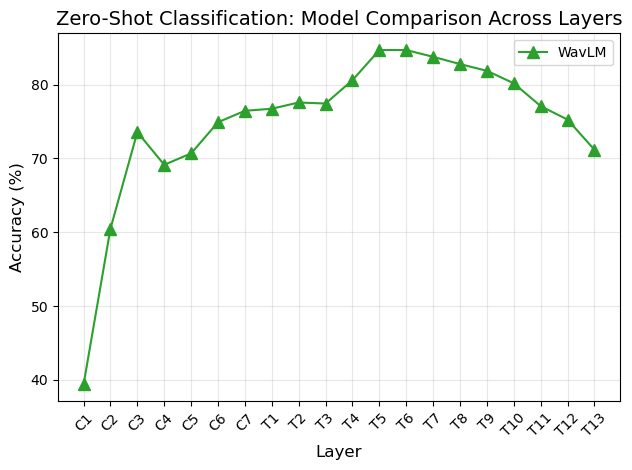

Saved linear probe comparison plot to output_plots/linear_probe_comparison.png


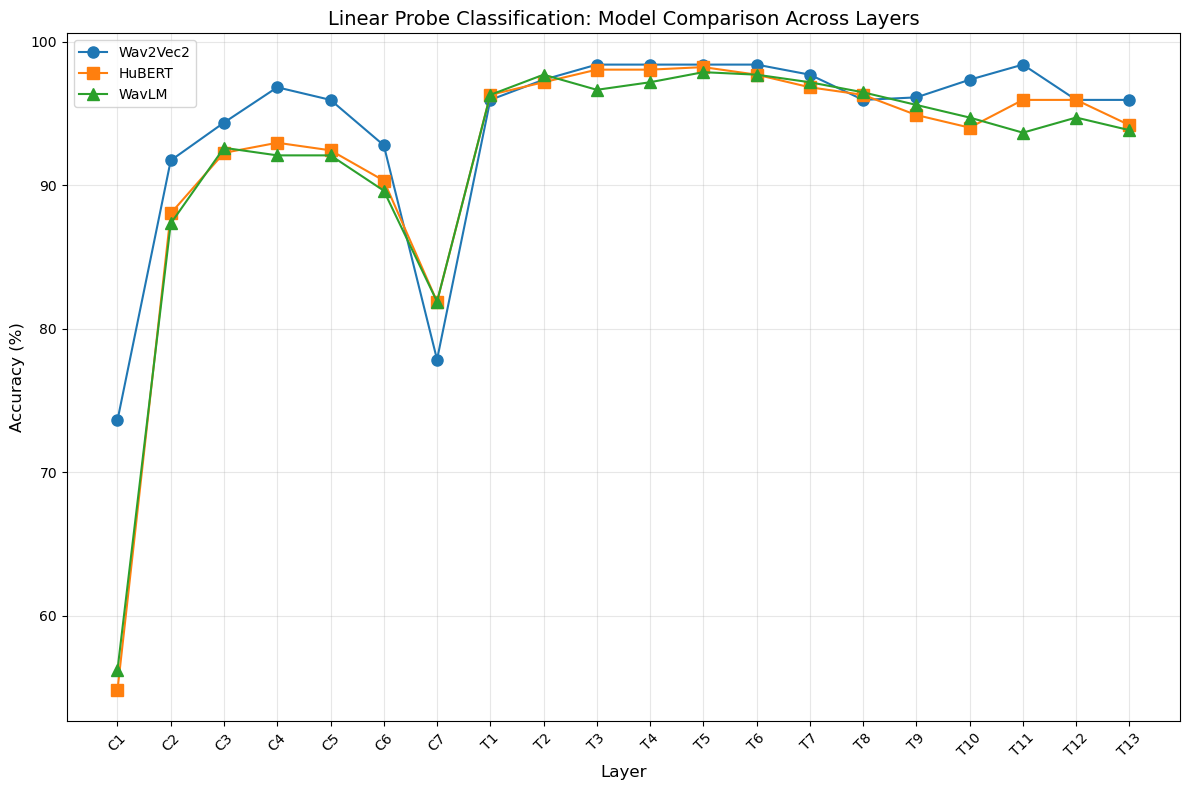


Analysis complete.

Time required  :  2429.354861974716


In [15]:
# ----------------------------
# Create Output Directory for Plots
# ----------------------------
plots_dir = "output_plots"
os.makedirs(plots_dir, exist_ok=True)

# ----------------------------
# Generate Zero-Shot Comparison Plot
# ----------------------------
plt.figure(figsize=(12, 8))

# Set markers and colors for each model
markers = ['o', 's', '^']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (model_label, model_data) in enumerate(models_data.items()):
    # Create x-axis labels for CNN layers
    cnn_labels = [f"C{i+1}" for i in range(model_data["num_cnn_layers"])]
    # Create x-axis labels for Transformer layers
    trans_labels = [f"T{i+1}" for i in range(model_data["num_transformer_layers"])]

    # Combine all labels and accuracy values
    x_labels = cnn_labels + trans_labels
    combined_zs_acc = model_data["cnn_zs_acc"] + model_data["transformer_zs_acc"]

    # Plot x-axis positions
    x = np.arange(len(x_labels))

    # Plot zero-shot accuracy with model-specific marker and color
    plt.plot(x, [acc * 100 for acc in combined_zs_acc],
                marker=markers[idx],
                color=colors[idx],
                label=f"{model_label}",
                markersize=8)

    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Zero-Shot Classification: Model Comparison Across Layers", fontsize=14)

    # Create custom x-ticks that show CNN (C) and Transformer (T) layers
    max_cnn = max([model_data["num_cnn_layers"] for model_data in models_data.values()])
    max_trans = max([model_data["num_transformer_layers"] for model_data in models_data.values()])
    custom_xticks = [f"C{i+1}" for i in range(max_cnn)] + [f"T{i+1}" for i in range(max_trans)]
    plt.xticks(np.arange(len(custom_xticks)), custom_xticks, rotation=45)

    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    zero_shot_plot_path = os.path.join(plots_dir, "zero_shot_comparison.png")
    plt.savefig(zero_shot_plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved zero-shot comparison plot to {zero_shot_plot_path}")
    plt.show()

    # ----------------------------
    # Generate Linear Probe Comparison Plot
    # ----------------------------
    plt.figure(figsize=(12, 8))

    for idx, (model_label, model_data) in enumerate(models_data.items()):
        # Create x-axis labels for CNN layers
        cnn_labels = [f"C{i+1}" for i in range(model_data["num_cnn_layers"])]
        # Create x-axis labels for Transformer layers
        trans_labels = [f"T{i+1}" for i in range(model_data["num_transformer_layers"])]

        # Combine all labels and accuracy values
        x_labels = cnn_labels + trans_labels
        combined_lp_acc = model_data["cnn_lp_acc"] + model_data["transformer_lp_acc"]

        # Plot x-axis positions
        x = np.arange(len(x_labels))

        # Plot linear probe accuracy with model-specific marker and color
        plt.plot(x, [acc * 100 for acc in combined_lp_acc],
                 marker=markers[idx],
                 color=colors[idx],
                 label=f"{model_label}",
                 markersize=8)

    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Linear Probe Classification: Model Comparison Across Layers", fontsize=14)

    # Create custom x-ticks that show CNN (C) and Transformer (T) layers
    max_cnn = max([model_data["num_cnn_layers"] for model_data in models_data.values()])
    max_trans = max([model_data["num_transformer_layers"] for model_data in models_data.values()])
    custom_xticks = [f"C{i+1}" for i in range(max_cnn)] + [f"T{i+1}" for i in range(max_trans)]
    plt.xticks(np.arange(len(custom_xticks)), custom_xticks, rotation=45)

    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    linear_probe_plot_path = os.path.join(plots_dir, "linear_probe_comparison.png")
    plt.savefig(linear_probe_plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved linear probe comparison plot to {linear_probe_plot_path}")
    plt.show()

    print("\nAnalysis complete.")

    end_time = time.time()
    print("\nTime required  : ", end_time - start_time)


Saved zero-shot comparison plot to output_plots/zero_shot_comparison.png


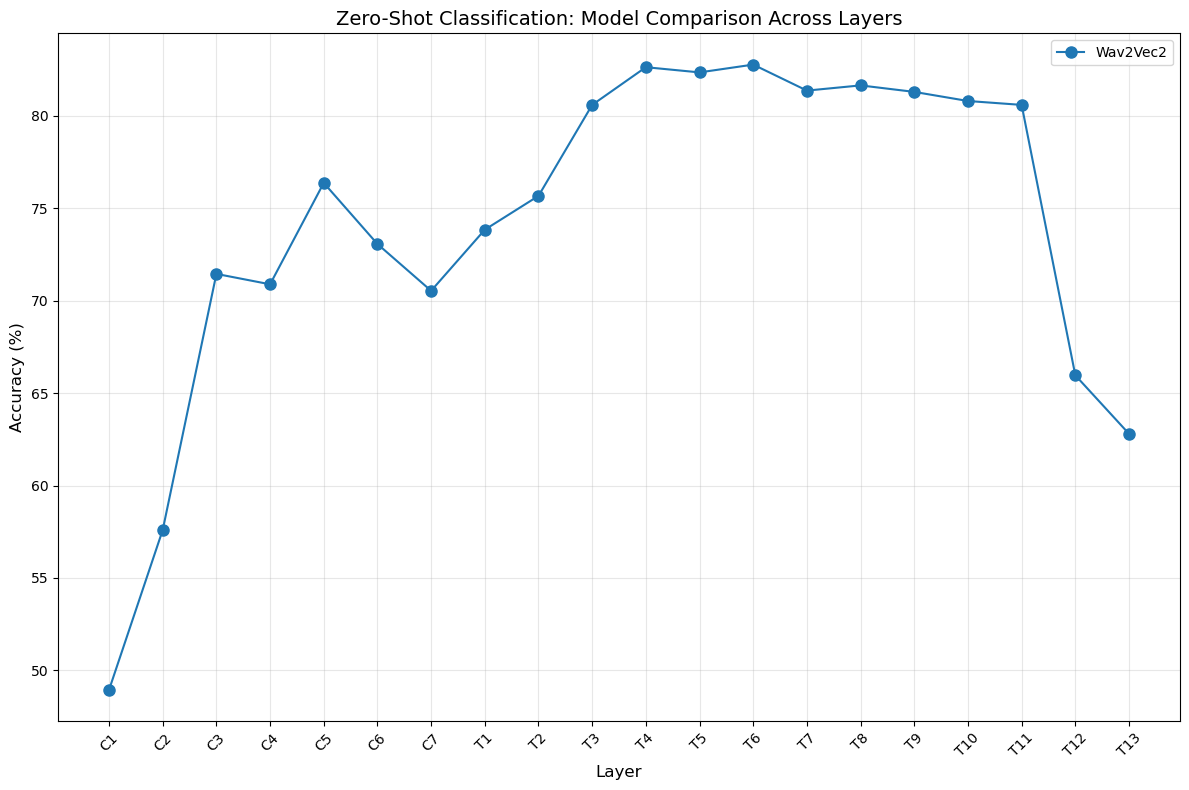

Saved zero-shot comparison plot to output_plots/zero_shot_comparison.png


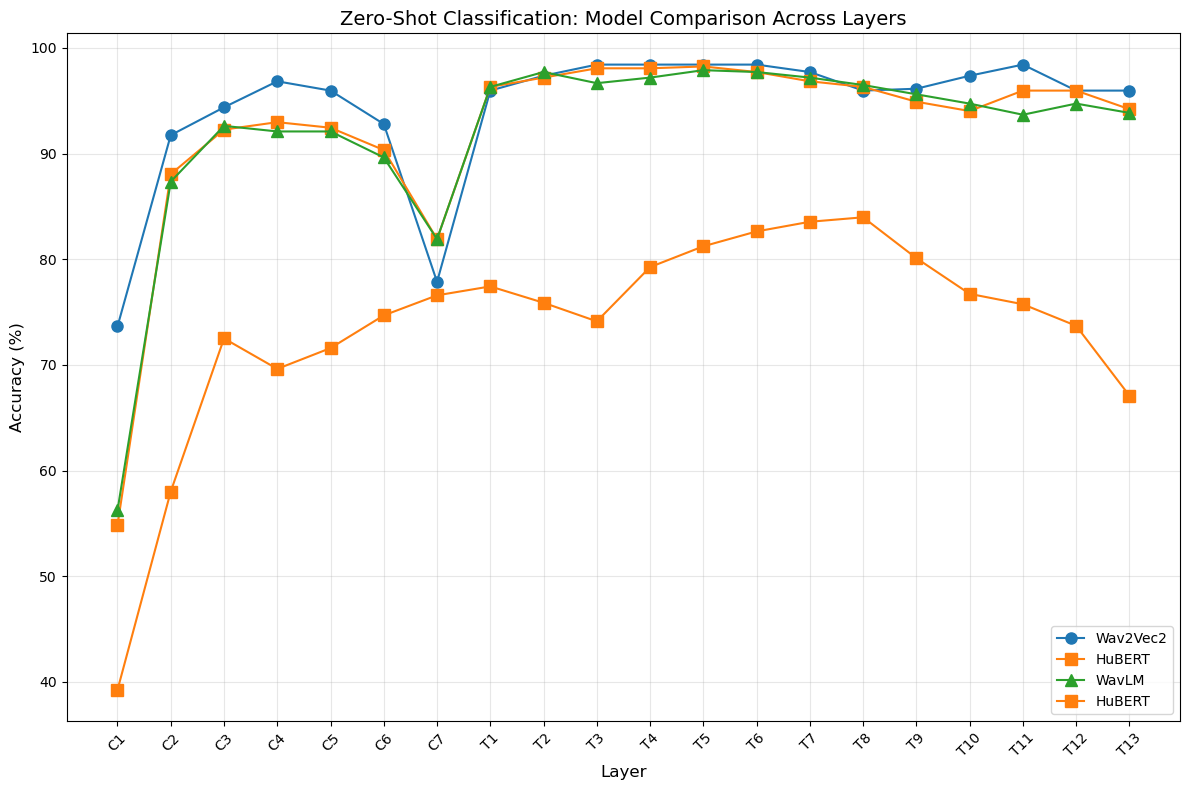

Saved zero-shot comparison plot to output_plots/zero_shot_comparison.png


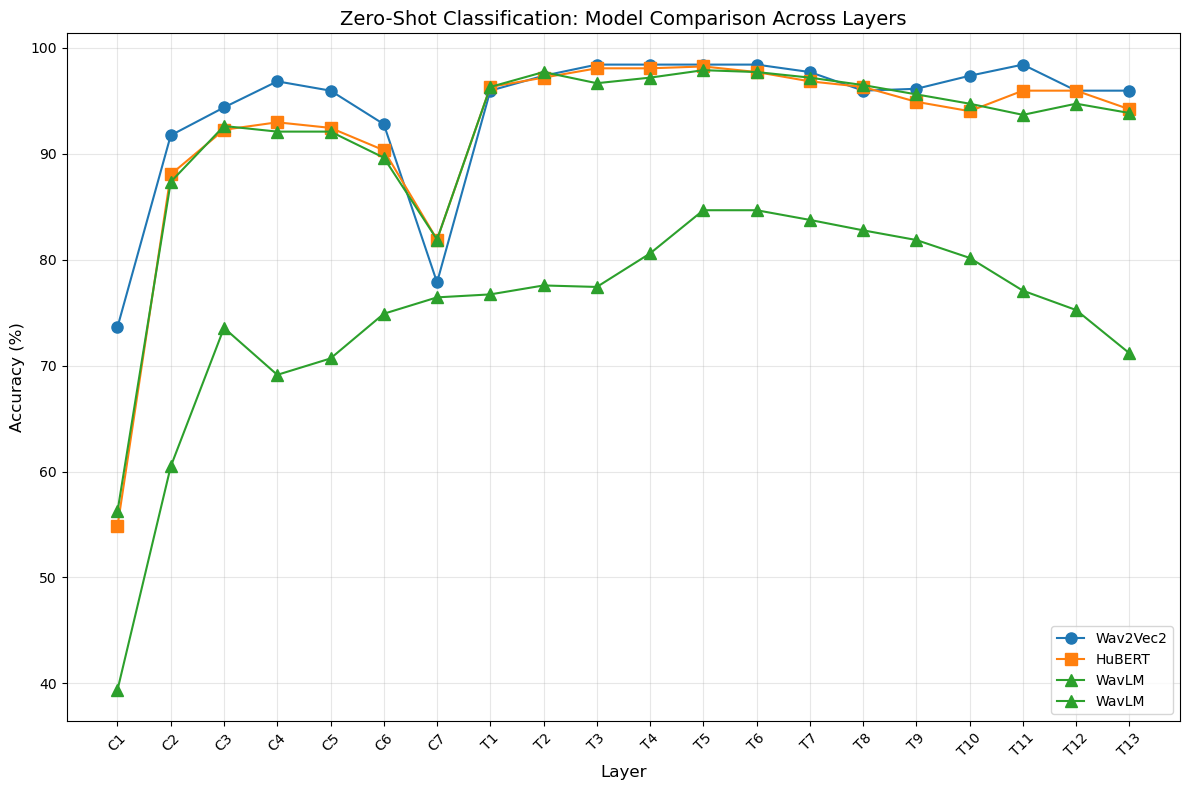

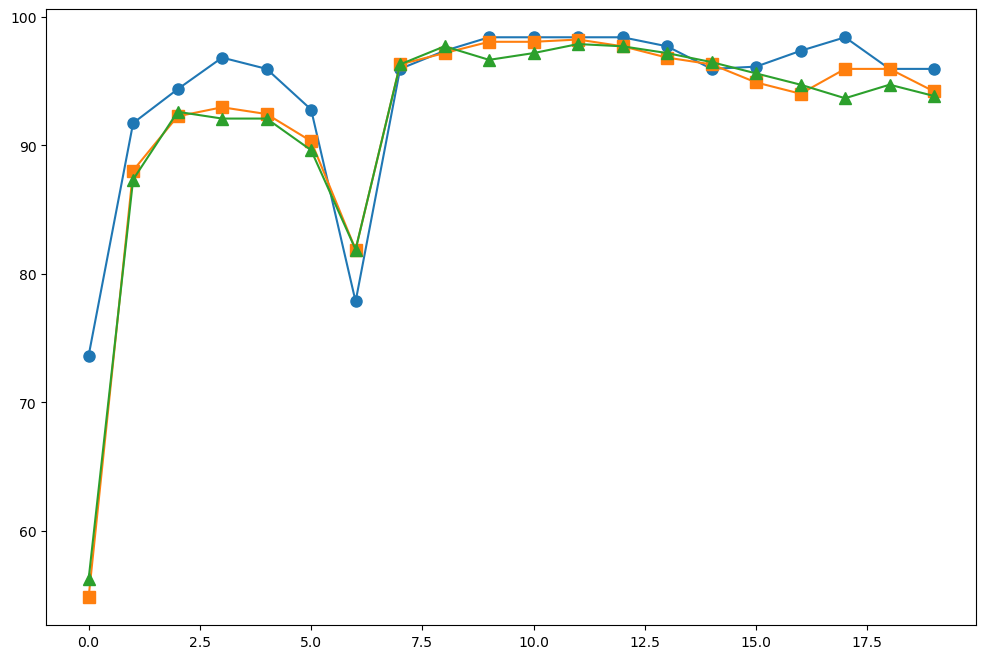

In [16]:
# ----------------------------
# Create Output Directory for Plots
# ----------------------------
plots_dir = "output_plots"
os.makedirs(plots_dir, exist_ok=True)

# ----------------------------
# Generate Zero-Shot Comparison Plot
# ----------------------------
plt.figure(figsize=(12, 8))

# Set markers and colors for each model
markers = ['o', 's', '^']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (model_label, model_data) in enumerate(models_data.items()):
    # Create x-axis labels for CNN layers
    cnn_labels = [f"C{i+1}" for i in range(model_data["num_cnn_layers"])]
    # Create x-axis labels for Transformer layers
    trans_labels = [f"T{i+1}" for i in range(model_data["num_transformer_layers"])]

    # Combine all labels and accuracy values
    x_labels = cnn_labels + trans_labels
    combined_zs_acc = model_data["cnn_zs_acc"] + model_data["transformer_zs_acc"]

    # Plot x-axis positions
    x = np.arange(len(x_labels))

    # Plot zero-shot accuracy with model-specific marker and color
    plt.plot(x, [acc * 100 for acc in combined_zs_acc],
                marker=markers[idx],
                color=colors[idx],
                label=f"{model_label}",
                markersize=8)

    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Zero-Shot Classification: Model Comparison Across Layers", fontsize=14)

    # Create custom x-ticks that show CNN (C) and Transformer (T) layers
    max_cnn = max([model_data["num_cnn_layers"] for model_data in models_data.values()])
    max_trans = max([model_data["num_transformer_layers"] for model_data in models_data.values()])
    custom_xticks = [f"C{i+1}" for i in range(max_cnn)] + [f"T{i+1}" for i in range(max_trans)]
    plt.xticks(np.arange(len(custom_xticks)), custom_xticks, rotation=45)

    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    zero_shot_plot_path = os.path.join(plots_dir, "zero_shot_comparison.png")
    plt.savefig(zero_shot_plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved zero-shot comparison plot to {zero_shot_plot_path}")
    plt.show()

    # ----------------------------
    # Generate Linear Probe Comparison Plot
    # ----------------------------
    plt.figure(figsize=(12, 8))

    for idx, (model_label, model_data) in enumerate(models_data.items()):
        # Create x-axis labels for CNN layers
        cnn_labels = [f"C{i+1}" for i in range(model_data["num_cnn_layers"])]
        # Create x-axis labels for Transformer layers
        trans_labels = [f"T{i+1}" for i in range(model_data["num_transformer_layers"])]

        # Combine all labels and accuracy values
        x_labels = cnn_labels + trans_labels
        combined_lp_acc = model_data["cnn_lp_acc"] + model_data["transformer_lp_acc"]

        # Plot x-axis positions
        x = np.arange(len(x_labels))

        # Plot linear probe accuracy with model-specific marker and color
        plt.plot(x, [acc * 100 for acc in combined_lp_acc],
                 marker=markers[idx],
                 color=colors[idx],
                 label=f"{model_label}",
                 markersize=8)


In [18]:
from datasets import load_dataset, load_from_disk

# Load the dataset (this downloads and caches it)
minds_14 = load_dataset("PolyAI/minds14", "fr-FR")

ModuleNotFoundError: No module named 'datasets'

In [ ]:
# Save the dataset to a custom folder path
custom_folder = "datasets/intent"
minds_14.save_to_disk(custom_folder)

# Later, load the dataset from the custom folder
minds_14 = load_from_disk(custom_folder)


README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

minds14.py:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


MInDS-14.zip:   0%|          | 0.00/471M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

In [ ]:
import os
import soundfile as sf
import pandas as pd
from datasets import load_from_disk

# Load the saved dataset (replace with your folder if needed)
dataset = load_from_disk("datasets/intent")

# Base folder where the WAV files will be saved
base_folder = "./wav_files_by_intent"
os.makedirs(base_folder, exist_ok=True)

csv_rows = []

# Process the available splits (e.g., train, validation, test)
for split in dataset.keys():
    for i, example in enumerate(dataset[split]):
        # Extract the audio sample.
        # The "audio" feature returns a dictionary with the keys "array" and "sampling_rate"
        audio_data = example["audio"]
        # In case the audio data isn't loaded yet, call the decoding function.
        # (For most cases, the datasets library does this automatically.)

        # Extract the intent index and get its corresponding name
        intent_index = example["intent_class"]
        intent = dataset[split].features["intent_class"].names[intent_index]

        # Create a folder for this intent if it doesn't already exist
        intent_folder = os.path.join(base_folder, intent)
        os.makedirs(intent_folder, exist_ok=True)

        # Define a file name (including split and index for uniqueness)
        file_name = f"{split}_{i}.wav"
        print(file_name)
        file_path = os.path.join(intent_folder, file_name)
        print(file_path)
        # Write the audio data to a WAV file
        sf.write(file_path, audio_data["array"], audio_data["sampling_rate"])

        # Optionally, record additional metadata such as transcription or the original path
        csv_rows.append({
            "file_path": file_path,
            "intent": intent,
            "transcription": example.get("transcription", ""),
            "english_transcription": example.get("english_transcription", ""),
            "split": split
        })

# Save the metadata to a CSV file
df = pd.DataFrame(csv_rows)
df.to_csv("audio_intent_mapping.csv", index=False)

print("Extraction complete: WAV files and CSV mapping have been created.")


train_0.wav
./wav_files_by_intent/address/train_0.wav
train_1.wav
./wav_files_by_intent/address/train_1.wav
train_2.wav
./wav_files_by_intent/address/train_2.wav
train_3.wav
./wav_files_by_intent/address/train_3.wav
train_4.wav
./wav_files_by_intent/address/train_4.wav
train_5.wav
./wav_files_by_intent/address/train_5.wav
train_6.wav
./wav_files_by_intent/address/train_6.wav
train_7.wav
./wav_files_by_intent/address/train_7.wav
train_8.wav
./wav_files_by_intent/address/train_8.wav
train_9.wav
./wav_files_by_intent/address/train_9.wav
train_10.wav
./wav_files_by_intent/address/train_10.wav
train_11.wav
./wav_files_by_intent/address/train_11.wav
train_12.wav
./wav_files_by_intent/address/train_12.wav
train_13.wav
./wav_files_by_intent/address/train_13.wav
train_14.wav
./wav_files_by_intent/address/train_14.wav
train_15.wav
./wav_files_by_intent/address/train_15.wav
train_16.wav
./wav_files_by_intent/address/train_16.wav
train_17.wav
./wav_files_by_intent/address/train_17.wav
train_18.wav

train_213.wav
./wav_files_by_intent/freeze/train_213.wav
train_214.wav
./wav_files_by_intent/freeze/train_214.wav
train_215.wav
./wav_files_by_intent/freeze/train_215.wav
train_216.wav
./wav_files_by_intent/freeze/train_216.wav
train_217.wav
./wav_files_by_intent/freeze/train_217.wav
train_218.wav
./wav_files_by_intent/freeze/train_218.wav
train_219.wav
./wav_files_by_intent/freeze/train_219.wav
train_220.wav
./wav_files_by_intent/freeze/train_220.wav
train_221.wav
./wav_files_by_intent/freeze/train_221.wav
train_222.wav
./wav_files_by_intent/balance/train_222.wav
train_223.wav
./wav_files_by_intent/balance/train_223.wav
train_224.wav
./wav_files_by_intent/balance/train_224.wav
train_225.wav
./wav_files_by_intent/balance/train_225.wav
train_226.wav
./wav_files_by_intent/balance/train_226.wav
train_227.wav
./wav_files_by_intent/balance/train_227.wav
train_228.wav
./wav_files_by_intent/balance/train_228.wav
train_229.wav
./wav_files_by_intent/balance/train_229.wav
train_230.wav
./wav_fil

train_420.wav
./wav_files_by_intent/cash_deposit/train_420.wav
train_421.wav
./wav_files_by_intent/direct_debit/train_421.wav
train_422.wav
./wav_files_by_intent/direct_debit/train_422.wav
train_423.wav
./wav_files_by_intent/direct_debit/train_423.wav
train_424.wav
./wav_files_by_intent/direct_debit/train_424.wav
train_425.wav
./wav_files_by_intent/direct_debit/train_425.wav
train_426.wav
./wav_files_by_intent/direct_debit/train_426.wav
train_427.wav
./wav_files_by_intent/direct_debit/train_427.wav
train_428.wav
./wav_files_by_intent/direct_debit/train_428.wav
train_429.wav
./wav_files_by_intent/direct_debit/train_429.wav
train_430.wav
./wav_files_by_intent/direct_debit/train_430.wav
train_431.wav
./wav_files_by_intent/direct_debit/train_431.wav
train_432.wav
./wav_files_by_intent/direct_debit/train_432.wav
train_433.wav
./wav_files_by_intent/direct_debit/train_433.wav
train_434.wav
./wav_files_by_intent/direct_debit/train_434.wav
train_435.wav
./wav_files_by_intent/direct_debit/train_